In [11]:
import xarray as xr

# here we are Loading the downloaded dataset
ds = xr.open_dataset(r"C:\Users\VICTUS\Downloads\6dc1c3571a8ed721dd55cb6bb697e69.nc")

print(ds)




<xarray.Dataset> Size: 297MB
Dimensions:     (valid_time: 720, latitude: 161, longitude: 641)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 1961-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 20.0 19.75 19.5 ... -19.5 -19.75 -20.0
  * longitude   (longitude) float64 5kB 120.0 120.2 120.5 ... 279.5 279.8 280.0
    expver      (valid_time) <U4 12kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 297MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-07T05:16 GRIB to CDM+CF via cfgrib-0.9.1...


In [13]:
import xarray as xr
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Loading the netcdf file which is downloaded 
ds = xr.open_dataset(r"C:\Users\VICTUS\Downloads\6dc1c3571a8ed721dd55cb6bb697e69.nc")

In [14]:
# creating and Selecting the sst variable
sst = ds['sst']

# here we are Renaming 'valid_time' to 'time' because getting error so print dataset and got the name issue
sst = sst.rename({'valid_time': 'time'})

In [16]:
# here we are Calculating the monthly climatology (average of all Januaries, all Februaries, so on for all months)
monthly_climatology = sst.groupby('time.month').mean(dim='time')

# Subtracting the climatology to get the anomaly means the different behaviour
sst_anomaly = sst.groupby('time.month') - monthly_climatology

In [4]:
# Calculating the square root of the cosine of latitude for weighting
cos_lat = np.cos(np.deg2rad(sst_anomaly.latitude))
weights = np.sqrt(cos_lat)

# here we are Applying the weight to the anomaly data
sst_anomaly_weighted = sst_anomaly * weights

In [17]:
# now after this we are Stacking latitude and longitude into a single 'space' dimension and dropping any all-NaN columns
flat_data = sst_anomaly_weighted.stack(space=('latitude', 'longitude')).dropna(dim='space', how='all')

# Fill any remaining NaN values with 0
flat_data = flat_data.fillna(0)

In [18]:
# Now in this step Initializing PCA to find the first 3 modes
n_modes = 3
pca = PCA(n_components=n_modes)

# Fitting the PCA model and getting the Principal Components 
principal_components = pca.fit_transform(flat_data)

# Getting the EOFs (the spatial patterns)
eofs = pca.components_

# now Getting the variance explained by each mode
variance_explained = pca.explained_variance_ratio_

Variance Explained by Each Mode:
  Mode 1: 48.93%
  Mode 2: 11.42%
  Mode 3: 7.95%


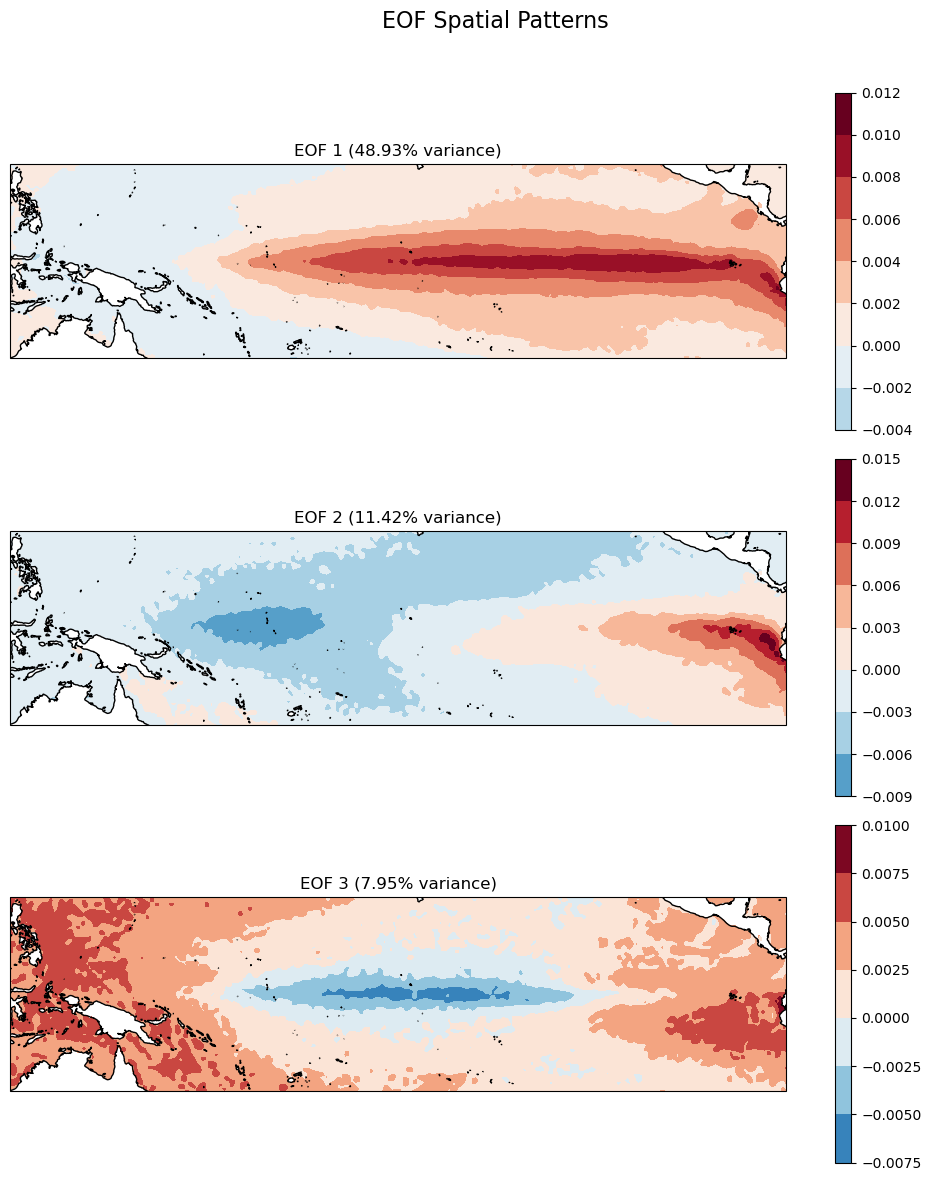

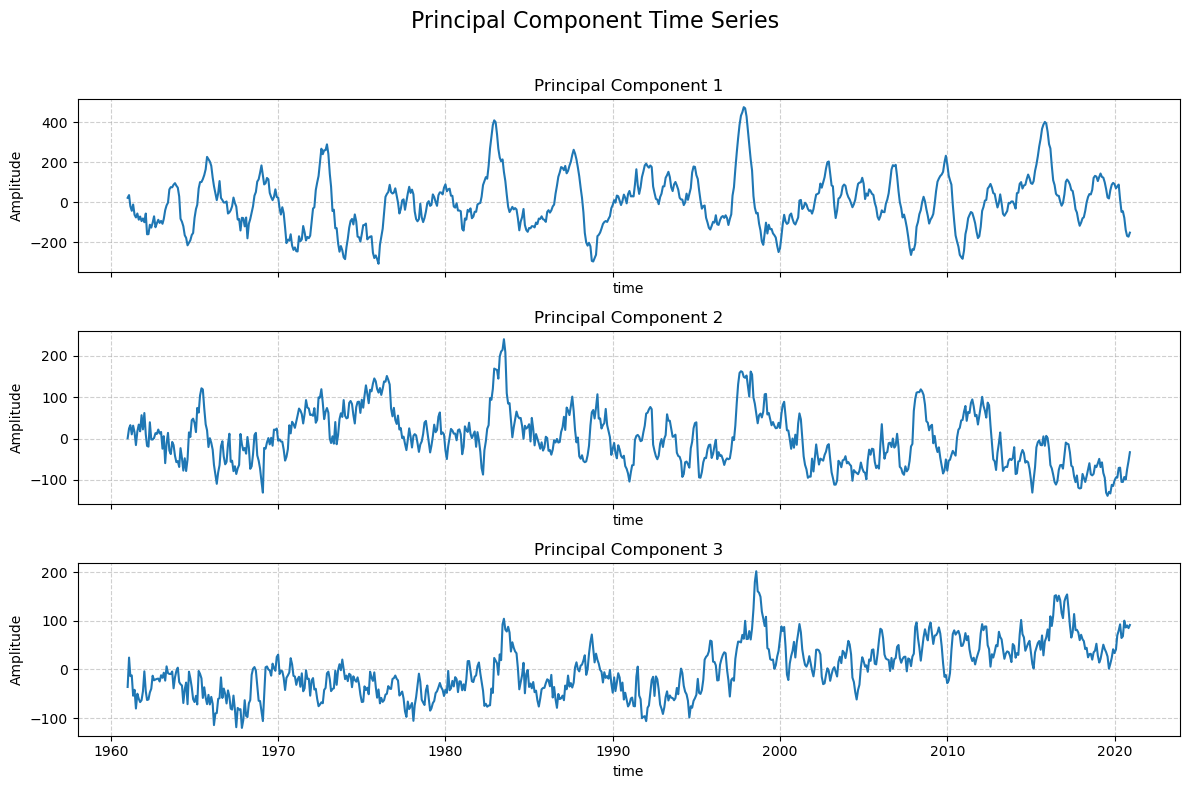

In [19]:
# 1 Reporting the variance explained
print("Variance Explained by Each Mode:")
for i in range(n_modes):
    print(f"  Mode {i+1}: {variance_explained[i] * 100:.2f}%")

# 2 Reshaping the EOFs back into maps
eofs_unstacked = xr.DataArray(
    data=eofs,
    dims=('mode', 'space'),
    coords={'mode': np.arange(1, n_modes + 1), 'space': flat_data.space}
).unstack('space')

# 3 here we are Creating the EOF plots
fig_eofs, axes_eofs = plt.subplots(n_modes, 1, figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
fig_eofs.suptitle('EOF Spatial Patterns', fontsize=16)
for i in range(n_modes):
    ax = axes_eofs[i]
    eofs_unstacked.sel(mode=i+1).plot.contourf(
        ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=True
    )
    ax.coastlines()
    ax.set_title(f'EOF {i+1} ({variance_explained[i]*100:.2f}% variance)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4 here we are Creating the PC plots
pcs_da = xr.DataArray(
    data=principal_components,
    dims=('time', 'mode'),
    coords={'time': flat_data.time, 'mode': np.arange(1, n_modes + 1)}
)
fig_pcs, axes_pcs = plt.subplots(n_modes, 1, figsize=(12, 8), sharex=True)
fig_pcs.suptitle('Principal Component Time Series', fontsize=16)
for i in range(n_modes):
    ax = axes_pcs[i]
    pcs_da.sel(mode=i+1).plot(ax=ax)
    ax.set_title(f'Principal Component {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()